# 190. Keras API 와 LSTM 을 이용한 이상한 나라의 Alice 문장 생성기

- next word 예측

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
import tensorflow.keras.regularizers as regularizers
import numpy as np 

In [6]:
path_to_file = tf.keras.utils.get_file('alice.txt', "http://www.gutenberg.org/files/11/11.txt")

In [7]:
r = open(path_to_file, 'r')
texts = r.readlines()
lines = []

for line in texts:
    line = line.strip().lower()
    if len(line) == 0:
        continue
    lines.append(line)

text = " ".join(lines)
text[:1000]

"project gutenberg's alice's adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title: alice's adventures in wonderland author: lewis carroll posting date: june 25, 2008 [ebook #11] release date: march, 1994 [last updated: december 20, 2011] language: english character set encoding: ascii *** start of this project gutenberg ebook alice's adventures in wonderland *** alice's adventures in wonderland lewis carroll the millennium fulcrum edition 3.0 chapter i. down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought alice 'without p

In [0]:
import re

corpus = re.split('[,.]', text)

In [6]:
corpus[:10]

["project gutenberg's alice's adventures in wonderland",
 ' by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever',
 '  you may copy it',
 ' give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www',
 'gutenberg',
 "org title: alice's adventures in wonderland author: lewis carroll posting date: june 25",
 ' 2008 [ebook #11] release date: march',
 ' 1994 [last updated: december 20',
 " 2011] language: english character set encoding: ascii *** start of this project gutenberg ebook alice's adventures in wonderland *** alice's adventures in wonderland lewis carroll the millennium fulcrum edition 3",
 '0 chapter i']

In [7]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

3338


In [8]:
list(tokenizer.index_word.items())[10:15]

[(11, 'you'), (12, 'alice'), (13, 'was'), (14, 'i'), (15, 'that')]

In [9]:
list(tokenizer.word_index.items())[10:15]

[('you', 11), ('alice', 12), ('was', 13), ('i', 14), ('that', 15)]

In [0]:
# create input sequences using list of tokens
input_sequences = []

for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [11]:
print(len(input_sequences))
input_sequences[:10]

27218


[[48, 1303],
 [48, 1303, 248],
 [48, 1303, 248, 342],
 [48, 1303, 248, 342, 10],
 [48, 1303, 248, 342, 10, 481],
 [59, 815],
 [59, 815, 816],
 [59, 815, 816, 22],
 [59, 815, 816, 22, 443],
 [59, 815, 816, 22, 443, 31]]

In [12]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences

array([[   0,    0,    0, ...,    0,   48, 1303],
       [   0,    0,    0, ...,   48, 1303,  248],
       [   0,    0,    0, ..., 1303,  248,  342],
       ...,
       [   0,    0,    0, ...,    4,  275,   40],
       [   0,    0,    0, ...,  275,   40,  494],
       [   0,    0,    0, ...,   40,  494,  621]], dtype=int32)

In [0]:
text_dataset = tf.data.Dataset.from_tensor_slices(input_sequences)

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[-1]
    return input_text, target_text

In [15]:
dataset = text_dataset.map(split_input_target).batch(256, drop_remainder=True)

for input, target in dataset.take(1):
    print(input)
    print()
    print(target)

tf.Tensor(
[[   0    0    0 ...    0    0   48]
 [   0    0    0 ...    0   48 1303]
 [   0    0    0 ...   48 1303  248]
 ...
 [   0    0    0 ...    8 1317    4]
 [   0    0    0 ... 1317    4   17]
 [   0    0    0 ...    4   17   15]], shape=(256, 62), dtype=int32)

tf.Tensor(
[1303  248  342   10  481  815  816   22  443   31   24    1  151    6
  704 1006   19   49  817    3   18  482   49 1304 1305  175  343    8
    8  169   27 1306  151    8  203    1  204    6    1   48   44  258
 1007   18   22  443   27  818   19  625 1826  248  342   10  481 1827
  815  816 1828  819 1829 1830  443  820 1832  819  136  140 1307 1834
 1308 1836  550 1309  196 1837 1008 1009    6   22   48   44  443  248
  342   10  481  248  342   10  481  815  816    1 1838 1839 1310  373
  344   14    1  110  705   12   13  274    4  115   29  551    6  405
   59   17  483   20    1 1010    6  406  154    4   45  148   27  706
    7   23 1011   68    1  374   17  483   13  821    8   23   49  822
   27 13

In [16]:
model = Sequential()
model.add(Embedding(total_words, 100))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         333800    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          34048     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1669)              28373     
_________________________________________________________________
dense_1 (Dense)              (None, 3338)              5574460   
Total params: 5,975,865
Trainable params: 5,975,865
Non-trainable params: 0
______________________________________________

In [17]:
%%time
history = model.fit(dataset, epochs=150, verbose=1)

Epoch 1/150
106/106 [==============================] - 2s 22ms/step - loss: 6.8931 - accuracy: 0.0587
Epoch 2/150
106/106 [==============================] - 2s 22ms/step - loss: 6.2945 - accuracy: 0.0622
Epoch 3/150
106/106 [==============================] - 2s 22ms/step - loss: 6.1791 - accuracy: 0.0622
Epoch 4/150
106/106 [==============================] - 2s 22ms/step - loss: 6.1325 - accuracy: 0.0623
Epoch 5/150
106/106 [==============================] - 2s 22ms/step - loss: 6.0596 - accuracy: 0.0659
Epoch 6/150
106/106 [==============================] - 2s 22ms/step - loss: 5.9686 - accuracy: 0.0671
Epoch 7/150
106/106 [==============================] - 2s 22ms/step - loss: 5.9036 - accuracy: 0.0717
Epoch 8/150
106/106 [==============================] - 2s 22ms/step - loss: 5.8539 - accuracy: 0.0746
Epoch 9/150
106/106 [==============================] - 2s 22ms/step - loss: 5.7970 - accuracy: 0.0775
Epoch 10/150
106/106 [==============================] - 2s 22ms/step - loss: 5.730

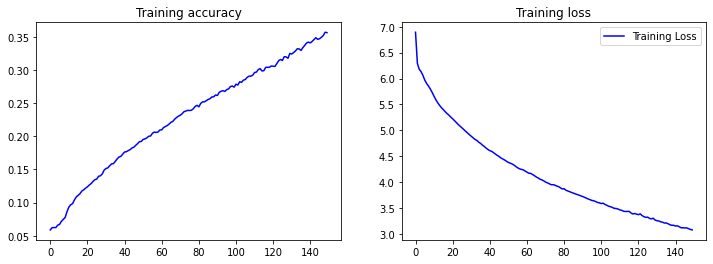

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [19]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = tokenizer.index_word[predicted[0]]
    seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope it ' the jury a sea before had ' and the mouse looked at the mouse all as your verdict but some turtle have happened to the united states without paying as a bit ' said the king the king and your tongue ' said the king she said the gryphon as it was a low voice and she had got up to the united states without paying as a low voice and she had been examining the united states in the united states without paying distributed high a great deal as she had not done a hurry to find
